# Some Analysis

Price analysis for generating the datasets and some potential graphs for the report.

In [2]:
import pandas as pd
import json
import openai


In [63]:
df = pd.read_csv("./data/gpt_4_data_qa.csv")
GPT = 4

In [57]:
if GPT == 3:
    MODEL = "gpt-3.5-turbo-1106"
    FILENAME = "gpt_3.5_data_qa.csv"
    PROMPT_COST = 0.001                     # Price per 1000 prompt tokens for GPT-3.5-turbo-1106 as of 12/22/2023
    COMPLETION_COST = 0.002                 # Price per 1000 completion tokens for GPT-3.5-turbo-1106 as of 12/22/2023
    N_CONCURRENT = 14                       # My limit is 160_000 token/min, so 14 concurrent requests works well
elif GPT == 4:
    MODEL = "gpt-4-1106-preview"
    FILENAME = "gpt_4_data_qa.csv"
    PROMPT_COST = 0.01                      # Price per 1000 prompt tokens for GPT-4-1106-preview as of 12/22/2023
    COMPLETION_COST = 0.03                  # Price per 1000 completion tokens for GPT-4-1106-preview as of 12/22/2023
    N_CONCURRENT = 20                       # My limit is 300_000 token/min limit, so 20 concurrent requests works well

In [58]:
PROMPT_COST

0.01

In [59]:
total = 0

for i in range(len(df)):
    try:
        usage = json.loads(df['api_res'][i])['usage']
        total += usage['prompt_tokens']/1000 * PROMPT_COST
        total += usage['completion_tokens']/1000 * COMPLETION_COST
    except:
        pass

print(f"Total cost: ${total:.3f}")

Total cost: $62.644


In [42]:
total

4.355006000000025

In [27]:
json.loads(df['api_res'][0])['usage']

{'prompt_tokens': 340, 'completion_tokens': 380, 'total_tokens': 720}

In [38]:
from matplotlib import pyplot as plt

df = pd.read_csv("./data/categorized_data.csv")
df = df[df['category'].notna()]

In [48]:
df['category'].isin(['admissions']).value_counts()

category
False    2636
True       46
Name: count, dtype: int64

In [39]:
df['category'].unique()

array(['about', 'academics', 'admissions', 'alumni', 'bsg', 'graduate',
       'library', 'life', 'live', 'research-foundation',
       'scholarships-aid', 'support'], dtype=object)

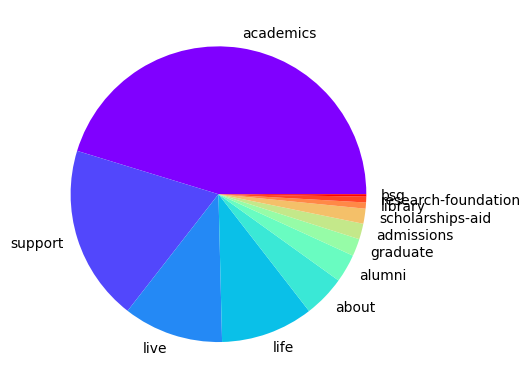

In [44]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

cs = cm.rainbow(np.linspace(0, 1, len(df['category'].unique())))
df.groupby(['category']).size().sort_values(ascending=False).plot(kind='pie', colors=cs)

plt.show()


In [68]:
from datasets import load_dataset

dataset = load_dataset("msaad02/brockport-gpt-4-qa")
df = dataset['train'].to_pandas()

In [69]:
df['url']

0                              https://www2.brockport.edu/
1                              https://www2.brockport.edu/
2                              https://www2.brockport.edu/
3                              https://www2.brockport.edu/
4                              https://www2.brockport.edu/
                               ...                        
11577    https://www2.brockport.edu/support/university-...
11578    https://www2.brockport.edu/support/university-...
11579    https://www2.brockport.edu/support/university-...
11580    https://www2.brockport.edu/support/university-...
11581    https://www2.brockport.edu/support/university-...
Name: url, Length: 11582, dtype: object

In [70]:
df['category']

KeyError: 'category'

In [71]:
df.loc[["brockport.edu/admissions" in url or "brockport.edu/scholarships-aid/" in url for url in df['url']]]

,url,question,answer
6693,https://www2.brockport.edu/admissions/,How can I learn more about the undergraduate p...,We're thrilled to hear you're interested in ou...
6694,https://www2.brockport.edu/admissions/,What financial aid opportunities are available...,"At SUNY Brockport, we understand the importanc..."
6695,https://www2.brockport.edu/admissions/,How can I schedule a visit to SUNY Brockport's...,We would love to show you around our vibrant c...
6696,https://www2.brockport.edu/admissions/,What diversity and opportunity programs does S...,"SUNY Brockport proudly values equity, diversit..."
6697,https://www2.brockport.edu/admissions/,I've been accepted to SUNY Brockport for gradu...,Congratulations on your acceptance! Your next ...
...,...,...,...
10769,https://www2.brockport.edu/scholarships-aid/sc...,What are the eligibility criteria for transfer...,We're thrilled you're interested in joining ou...
10770,https://www2.brockport.edu/scholarships-aid/sc...,How much can I receive from a transfer scholar...,We're excited to offer transfer scholarships t...
10771,https://www2.brockport.edu/scholarships-aid/sc...,Is there a separate application for transfer s...,Great question! There's no need for a separate...
10772,https://www2.brockport.edu/scholarships-aid/sc...,Will my GPA from all previous institutions aff...,Absolutely! We take a comprehensive look at yo...


In [72]:
373/len(df) * 100

3.220514591607667

In [66]:
pd.read_csv("./data/categorized_data.csv")['category'].value_counts()

category
academics              1214
support                 515
live                    293
life                    271
about                   123
alumni                   83
graduate                 51
admissions               46
scholarships-aid         44
library                  18
research-foundation      17
bsg                       7
Name: count, dtype: int64

In [20]:
from datasets import load_dataset, Dataset
import pandas as pd
import json

RAW_SCRAPER_OUTPUT = "data/raw_scraper_output.json"
GPT_3_5_DATA_QA = "data/gpt_3.5_data_qa.csv"

def get_qa_dataset(df: pd.DataFrame) -> Dataset:
    """
    Creates a huggingface dataset from the outfiles of 3_qa_generation.py.

    Note that this ignores null API responses.
    """
    questions = []
    for _, row in df.loc[df['questions'].notnull(), ['url', 'questions']].iterrows():
        url, question = row['url'], row['questions']

        list_of_questions = json.loads(question)
        list_of_questions = [{
            'url': url, 
            'question': q['question'], 
            'answer': q['answer']
        } for q in list_of_questions]

        questions.extend(list_of_questions)

    dataset = Dataset.from_list(questions)
    dataset = dataset.train_test_split(test_size=0.1)
    return dataset

# GPT-3.5
gpt35_dataset = get_qa_dataset(pd.read_csv(GPT_3_5_DATA_QA))
gpt35_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'question', 'answer'],
        num_rows: 11134
    })
    test: Dataset({
        features: ['url', 'question', 'answer'],
        num_rows: 1238
    })
})

In [21]:
gpt35_dataset['train']

Dataset({
    features: ['url', 'question', 'answer'],
    num_rows: 11134
})

In [9]:
df
questions = []
for _, row in df.loc[df['questions'].notnull(), ['url', 'questions']].iterrows():
    url, question = row['url'], row['questions']

    list_of_questions = json.loads(question)
    list_of_questions = [{
        'url': url, 
        'question': q['question'], 
        'answer': q['answer']
    } for q in list_of_questions]

    questions.extend(list_of_questions)


mapping = questions
mapping = {k: [r.get(k) for r in mapping] for k in mapping[0]} if mapping else {}

In [13]:
Dataset.from_dict(mapping, split="test[:20%]")

Dataset({
    features: ['url', 'question', 'answer'],
    num_rows: 12372
})